In [27]:
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from sklearn.model_selection import train_test_split

In [12]:
acb=pd.read_csv('ACB.csv')
acb

,Ticker,Date,Open,High,Low,Close,Volume
0,ACB,11/21/2006,5.307480,6.634350,5.263251,5.970915,56500.0
1,ACB,11/22/2006,6.552402,6.552402,5.948410,6.177195,62300.0
2,ACB,11/23/2006,6.435535,6.435535,5.769790,6.346769,69900.0
3,ACB,11/24/2006,6.283060,6.821608,6.283060,6.731850,63600.0
4,ACB,11/27/2006,6.959641,7.651813,6.400215,6.732078,42400.0
...,...,...,...,...,...,...,...
4307,ACB,03/07/2024,27.600000,27.700000,27.400000,27.500000,10165800.0
4308,ACB,03/08/2024,27.500000,27.650000,27.000000,27.050000,23017000.0
4309,ACB,03/11/2024,27.050000,27.100000,26.650000,26.750000,12015800.0
4310,ACB,03/12/2024,26.650000,26.850000,26.600000,26.750000,8312600.0


In [13]:
print(acb.dtypes)

Ticker     object
Date       object
Open      float64
High      float64
Low       float64
Close     float64
Volume    float64
dtype: object


In [14]:
acb=acb[['Date', 'Close']]
acb['Date'] = pd.to_datetime(acb['Date'])


C:\Users\DELL\AppData\Local\Temp\ipykernel_25284\2150580242.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [15]:
acb['Date'].min(), acb['Date'].max()

(Timestamp('2006-11-21 00:00:00'), Timestamp('2024-03-13 00:00:00'))

In [16]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=acb['Date'], y=acb['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='ACB Stock Price')
fig.show()

In [70]:
train, test = acb.loc[acb['Date'] <= '2019-12-01'], acb.loc[acb['Date'] > '2019-12-01']
train.shape, test.shape


((3248, 2), (1064, 2))

In [71]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

C:\Users\DELL\AppData\Local\Temp\ipykernel_25284\1980345901.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\DELL\AppData\Local\Temp\ipykernel_25284\1980345901.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [72]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])

In [73]:
print(f'Training shape: {X_train.shape}')

print(f'Testing shape: {X_test.shape}')

Training shape: (3218, 30, 1)
Testing shape: (1034, 30, 1)


In [74]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1]))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2])))
model.compile(optimizer='adam', loss='mae')
model.summary()

C:\Users\DELL\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:205: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_vector_2 (RepeatVector)  │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 30, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_2              │ (None, 30, 1)          │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 198,273 (774.50 KB)

 Trainable params: 198,273 (774.50 KB)

 Non-trainable params: 0 (0.00 B)

In [86]:
history = model.fit(X_train, y_train, epochs=150, batch_size=60, validation_split=0.1,
                    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, mode='min')], shuffle=False)

Epoch 1/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 161ms/step - loss: 0.3154 - val_loss: 0.1542
Epoch 2/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 178ms/step - loss: 0.2843 - val_loss: 0.1359
Epoch 3/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 190ms/step - loss: 0.2785 - val_loss: 0.1337
Epoch 4/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 183ms/step - loss: 0.2787 - val_loss: 0.1327
Epoch 5/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 179ms/step - loss: 0.2794 - val_loss: 0.1313
Epoch 6/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 174ms/step - loss: 0.2789 - val_loss: 0.1318
Epoch 7/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 171ms/step - loss: 0.2807 - val_loss: 0.1298
Epoch 8/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 182ms/step - loss: 0.2809 - val_loss: 0.1298
Epoch 9/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - loss: 0.2798 - val_loss: 0.1302
Epoch 10/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 8s 155ms/step - loss: 0.2801 - val_loss: 0.1287
Epoch 11/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 9s 193ms/step - loss: 0.2818 - val_loss: 0.1289
Epoch 12/150
49/49 ━━━━━━━━━━━━━━━━━━━━ 9

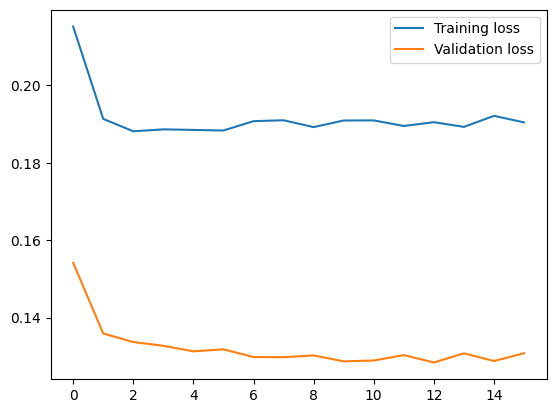

In [87]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

In [88]:
model.evaluate(X_test, y_test)

33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 1.2921


2.1861891746520996

Reconstruction error threshold: 0.9020400609814933


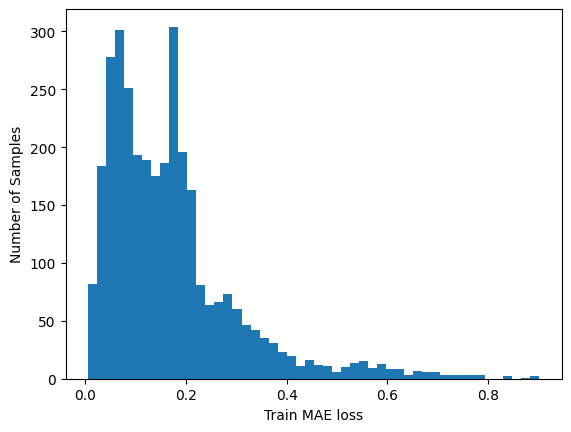

In [89]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples')

threshold = np.max(train_mae_loss)
print(f'Reconstruction error threshold: {threshold}')

Text(0, 0.5, 'Number of samples')

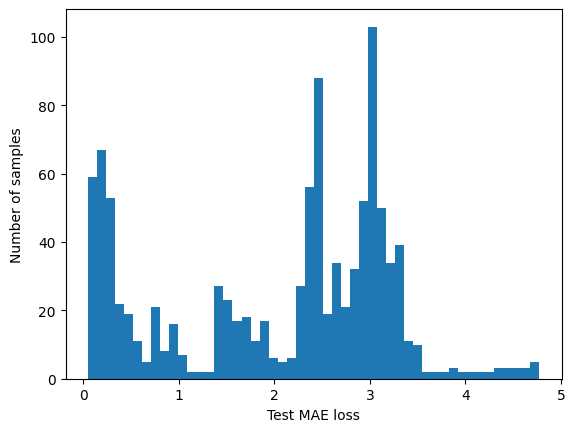

In [90]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples')

In [91]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test[TIME_STEPS:]['Close']

In [92]:
test_score_df.tail()

,Date,Close,loss,threshold,anomaly
4307,2024-03-07,8.554448,4.698395,0.90204,True
4308,2024-03-08,8.377767,4.725650,0.90204,True
4309,2024-03-11,8.259980,4.745859,0.90204,True
4310,2024-03-12,8.259980,4.758226,0.90204,True
4311,2024-03-13,8.613341,4.771249,0.90204,True


In [93]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [94]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.head()

,Date,Close,loss,threshold,anomaly
3530,2021-01-21,3.832048,0.920704,0.90204,True
3531,2021-01-22,3.769099,0.920155,0.90204,True
3532,2021-01-25,3.653687,0.932023,0.90204,True
3533,2021-01-26,3.590738,0.953322,0.90204,True
3534,2021-01-27,3.527784,0.974132,0.90204,True


In [95]:
anomalies.shape

(768, 5)

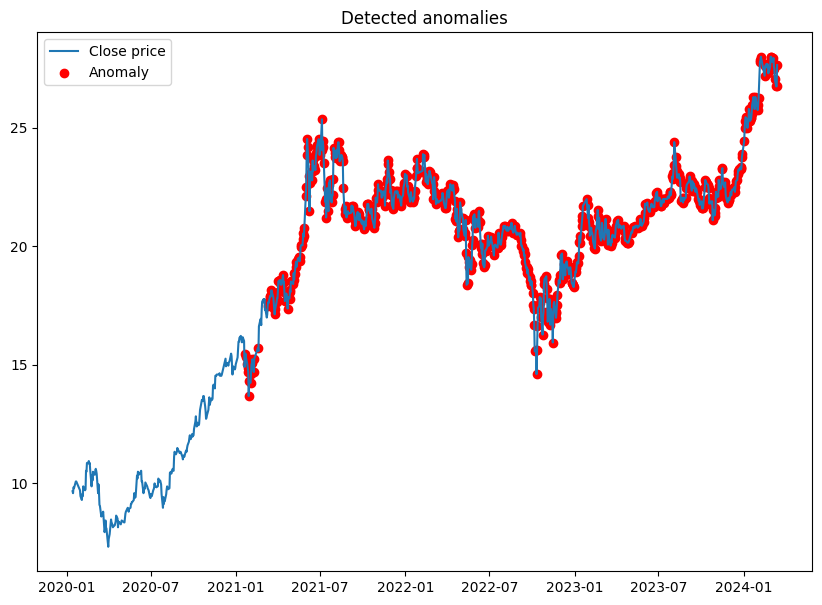

In [96]:
test_score_transformed = scaler.inverse_transform(test_score_df['Close'].values.reshape(-1, 1))
anomalies_transformed = scaler.inverse_transform(anomalies['Close'].values.reshape(-1, 1))

# Vẽ biểu đồ
plt.figure(figsize=(10, 7))
plt.plot(test_score_df['Date'], test_score_transformed, label='Close price')
plt.scatter(anomalies['Date'], anomalies_transformed, color='red', label='Anomaly')
plt.legend()
plt.title('Detected anomalies')
plt.show()